## Training UNet model for fire scar prediction 


In [4]:
### from scratch
# Getting normalization stats
import os
import glob
import rasterio
import numpy as np

merged_dir = 'data/merged'
merged_files = sorted(glob.glob(os.path.join(merged_dir, 'merged_ID*.tif')))

band_count = None
band_names = []
global_sum = []
global_sum_sq = []
global_pixel_count = []

for merged_path in merged_files:
    with rasterio.open(merged_path) as src:
        if band_count is None:
            band_count = src.count
            band_names = list(src.descriptions) if src.descriptions else [f'Band {i+1}' for i in range(band_count)]
            global_sum = [0.0] * band_count
            global_sum_sq = [0.0] * band_count
            global_pixel_count = [0] * band_count
        
        for i in range(1, band_count + 1):
            band = src.read(i).astype(np.float32)
            nodata = src.nodata
            if nodata is not None:
                band[band == nodata] = np.nan

            valid_pixels = ~np.isnan(band)
            band_valid = band[valid_pixels]

            if band_valid.size > 0:
                idx = i - 1
                global_sum[idx] += np.nansum(band_valid)
                global_sum_sq[idx] += np.nansum(band_valid**2)
                global_pixel_count[idx] += band_valid.size

global_mean = [s / c if c > 0 else np.nan for s, c in zip(global_sum, global_pixel_count)]
global_std = [
    np.sqrt((sq / c) - (m ** 2)) if c > 0 else np.nan
    for sq, c, m in zip(global_sum_sq, global_pixel_count, global_mean)
]

print("Global Mean and Std per Band:")
for i in range(band_count):
    print(f"{band_names[i]}: mean={global_mean[i]:.4f}, std={global_std[i]:.4f}")


Global Mean and Std per Band:
Ignition Point: mean=0.0000, std=0.0001
Distance to Water: mean=5813.8086, std=3816.9896
Heat Load: mean=0.5343, std=0.3222
Topographic Complexity: mean=2.2723, std=2.1330
Slope: mean=7.2479, std=8.2621
Elevation: mean=358.5952, std=388.9895
Aspect: mean=199.6984, std=92.1633
NDVI: mean=0.4463, std=0.1693
Fire History: mean=0.0016, std=0.0107
Time Since Last Fire: mean=32.2916, std=4.2432
Max Temperature Anomaly: mean=0.1813, std=0.8588
Minimum Temperature Anomaly: mean=0.1772, std=0.7127
Precipitation Anomaly: mean=-0.8084, std=16.6210
Accumulated Annual Precipitation: mean=397.8843, std=374.9523
Solar Radiation: mean=24350.4528, std=8524.3556
Water Vapor Pressure: mean=1.2697, std=0.1793
Wind Speed: mean=2.4683, std=0.4378
Distance to Road: mean=1514.8222, std=2101.6571
Distance to Population: mean=10193.7952, std=9285.8278
Population Density: mean=42.7422, std=101.3608


In [5]:
# Create PyTorch Dataset
import torch
from torch.utils.data import Dataset
import rasterio
import numpy as np
import os

class FireDataset(Dataset):
    def __init__(self, merged_dir, mask_dir, band_mean, band_std, transform=None):
        self.merged_dir = merged_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        self.ids = [f.split('_')[-1] for f in os.listdir(merged_dir) if f.startswith('merged_')]
        
        self.band_mean = torch.tensor(band_mean).view(-1, 1, 1)  # shape (bands,1,1)
        self.band_std = torch.tensor(band_std).view(-1, 1, 1)
        
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        id_ = self.ids[idx]
        merged_path = os.path.join(self.merged_dir, f'merged_{id_}')
        mask_path = os.path.join(self.mask_dir, f'mask_{id_}')
        
        with rasterio.open(merged_path) as src:
            merged = src.read().astype(np.float32)  # (bands, H, W)
            nodata = src.nodata
            if nodata is not None:
                merged[merged == nodata] = np.nan
        
        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.float32)
        
        # Normalize per band
        merged = torch.tensor(merged)
        mask = torch.tensor(mask).unsqueeze(0)  # (1,H,W)
        
        # Replace NaNs with 0 after normalization (or another strategy)
        merged = (merged - self.band_mean) / self.band_std
        merged = torch.nan_to_num(merged, nan=0.0)
        
        # Binarize mask
        mask = (mask > 0).float()
        
        if self.transform:
            merged, mask = self.transform(merged, mask)
        
        return merged, mask


In [6]:
# Train test split, data loaders
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import train_test_split

dataset = FireDataset(merged_dir, 'data/mask', global_mean, global_std)

train_ids, test_ids = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)

train_dataset = Subset(dataset, train_ids)
test_dataset = Subset(dataset, test_ids)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)


In [7]:
print(f"Train set size: {len(train_dataset)} samples")
print(f"Test set size: {len(test_dataset)} samples")


Train set size: 765 samples
Test set size: 192 samples


In [8]:
# Sanity check - normalization worked on small sample (n=30)
loader = DataLoader(dataset, batch_size=30, shuffle=True)
batch_merged, batch_mask = next(iter(loader))

print("Per-band mean (batch):", batch_merged.mean(dim=[0,2,3]))
print("Per-band std (batch):", batch_merged.std(dim=[0,2,3]))


Per-band mean (batch): tensor([-0.0053, -0.1057,  0.0302, -0.0092,  0.0072,  0.1310,  0.0183,  0.0795,
         0.0069,  0.0169, -0.1275, -0.1716, -0.0936,  0.0091,  0.0926, -0.1692,
        -0.1466,  0.1645,  0.1670, -0.0591], dtype=torch.float64)
Per-band std (batch): tensor([0.9412, 0.8888, 0.9809, 1.0670, 1.0655, 1.1149, 0.9737, 0.9926, 0.8481,
        0.9193, 0.8463, 0.8577, 0.8416, 1.0431, 1.2942, 1.1703, 0.8520, 1.1214,
        1.0979, 0.6181], dtype=torch.float64)


In [9]:
#### Model Training Setup ####

# Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Define augmentation pipeline for training
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
], additional_targets={'mask': 'mask'})

# For validation/test, no augmentation except conversion to tensor
val_transform = A.Compose([], additional_targets={'mask': 'mask'})

# Apply augmentation
class FireDataset(Dataset):
    def __init__(self, merged_dir, mask_dir, band_mean, band_std, transform=None):
        self.merged_dir = merged_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        self.ids = [f.split('_')[-1] for f in os.listdir(merged_dir) if f.startswith('merged_')]
        
        self.band_mean = torch.tensor(band_mean).view(-1, 1, 1)
        self.band_std = torch.tensor(band_std).view(-1, 1, 1)
        
    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, idx):
        id_ = self.ids[idx]
        merged_path = os.path.join(self.merged_dir, f'merged_{id_}')
        mask_path = os.path.join(self.mask_dir, f'mask_{id_}')
        
        with rasterio.open(merged_path) as src:
            merged = src.read().astype(np.float32)  # (bands, H, W)
            nodata = src.nodata
            if nodata is not None:
                merged[merged == nodata] = np.nan
        
        with rasterio.open(mask_path) as src:
            mask = src.read(1).astype(np.uint8)  # single band mask
        
        # Prepare for albumentations: (H, W, bands)
        merged = np.nan_to_num(merged, nan=0).transpose(1, 2, 0)
        
        # Apply augmentation
        if self.transform:
            augmented = self.transform(image=merged, mask=mask)
            merged = augmented['image']
            mask = augmented['mask']
        
        # Normalize bands and convert to tensor (C,H,W)
        merged = (merged - self.band_mean.numpy().transpose(1, 2, 0)) / self.band_std.numpy().transpose(1, 2, 0)
        merged = torch.tensor(merged.transpose(2, 0, 1), dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)  # add channel dim
        
        # Binarize mask just in case
        mask = (mask > 0).float()
        
        return merged, mask



/Users/abbystokes/anaconda3/envs/geoai/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [10]:
# CNN Segmentation Net
import torch.nn as nn
import torch.nn.functional as F

class SimpleSegmentationCNN(nn.Module):
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=1)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)  
        return x

In [11]:
# Training loop
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepare dataset and splits
dataset = FireDataset('data/merged', 'data/mask', global_mean, global_std, transform=train_transform)
train_ids, val_ids = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=42)
train_dataset = Subset(dataset, train_ids)
val_dataset = Subset(FireDataset('data/merged', 'data/mask', global_mean, global_std, transform=val_transform), val_ids)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Model, optimizer, loss
model = SimpleSegmentationCNN(in_channels=band_count).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#criterion = nn.BCELoss()
pos_weight = torch.tensor([10.0], device=device)  # try values from 5 to 50 depending on your dataset
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    for inputs, masks in train_loader:
        inputs = inputs.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_train_loss = running_loss / len(train_loader)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, masks in val_loader:
            inputs = inputs.to(device)
            masks = masks.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, masks)
            val_loss += loss.item()
    avg_val_loss = val_loss / len(val_loader)
    
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")


Epoch 1/5 - Train Loss: 0.3544 - Val Loss: 0.3999
Epoch 2/5 - Train Loss: 0.3116 - Val Loss: 0.3887
Epoch 3/5 - Train Loss: 0.3031 - Val Loss: 0.3743
Epoch 4/5 - Train Loss: 0.3031 - Val Loss: 0.3809
Epoch 5/5 - Train Loss: 0.3023 - Val Loss: 0.3640


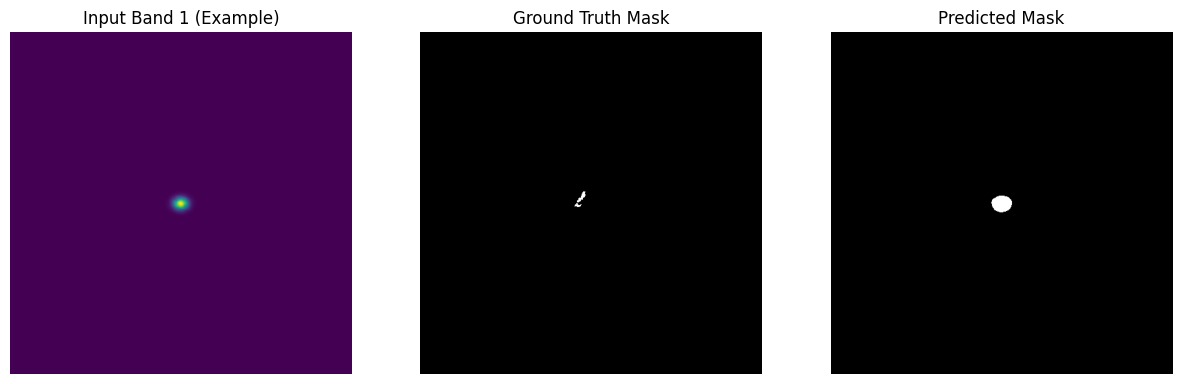

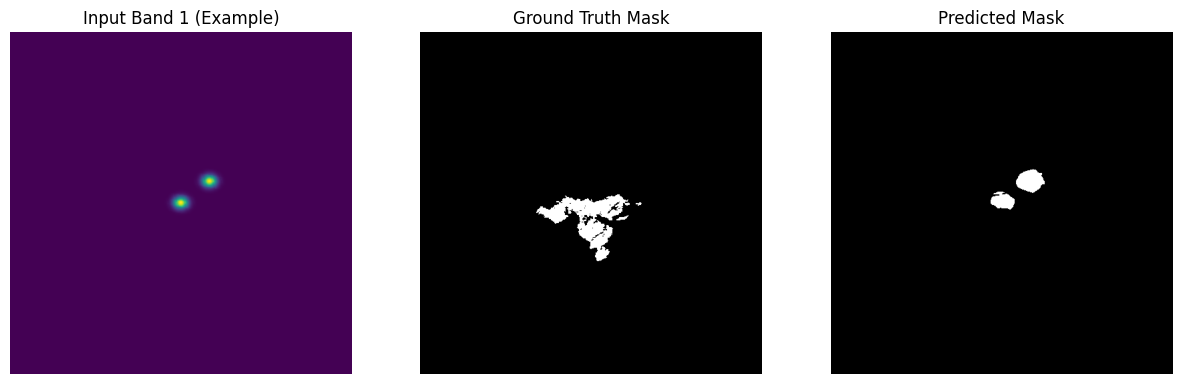

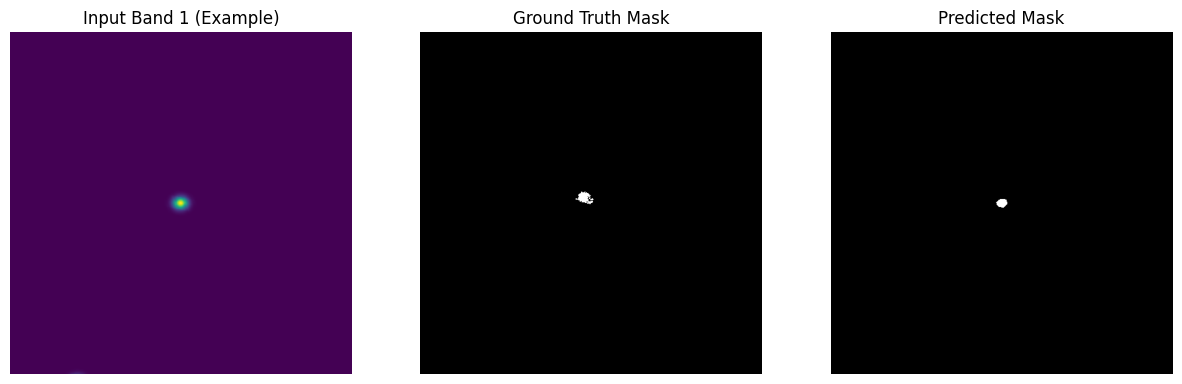

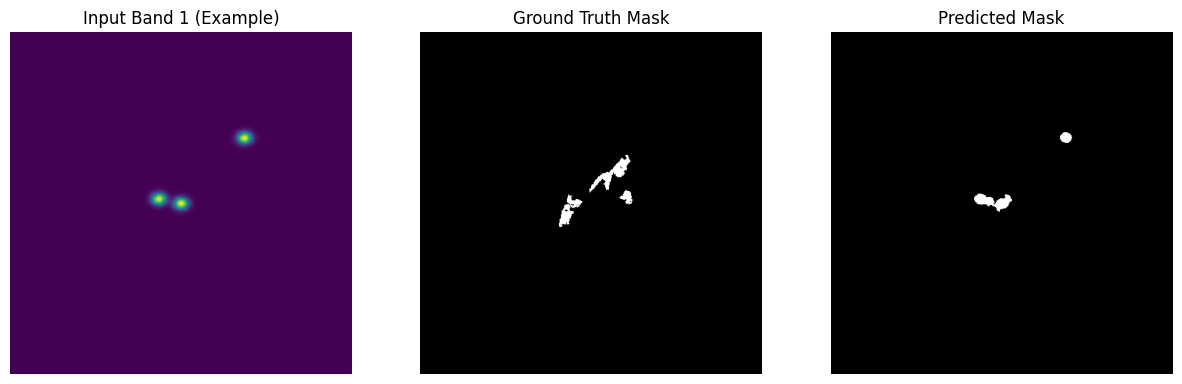

In [12]:
# Visualize prediction
import matplotlib.pyplot as plt

def visualize_predictions(model, dataloader, device, num_samples=4):
    model.eval()
    inputs, masks = next(iter(dataloader))
    inputs = inputs.to(device)
    masks = masks.to(device)
    
    with torch.no_grad():
        outputs = model(inputs)           # raw logits
        probs = torch.sigmoid(outputs)   # scale to [0, 1]
        preds = (probs > 0.5).float()    # binary mask
    inputs = inputs.cpu()
    masks = masks.cpu()
    preds = preds.cpu()
    
    for i in range(min(num_samples, inputs.size(0))):
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
        axs[0].imshow(inputs[i, 0], cmap='viridis')  # show first band as example
        axs[0].set_title('Input Band 1 (Example)')
        axs[0].axis('off')
        
        axs[1].imshow(masks[i, 0], cmap='gray')
        axs[1].set_title('Ground Truth Mask')
        axs[1].axis('off')
        
        axs[2].imshow(preds[i, 0], cmap='gray')
        axs[2].set_title('Predicted Mask')
        axs[2].axis('off')
        
        plt.show()

visualize_predictions(model, val_loader, device)



In [13]:
# Model evaluation
def iou_score(preds, targets, threshold=0.5, eps=1e-6):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum(dim=[1,2,3])
    union = (preds + targets).clamp(0,1).sum(dim=[1,2,3])
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()

def dice_score(preds, targets, threshold=0.5, eps=1e-6):
    preds = (preds > threshold).float()
    intersection = (preds * targets).sum(dim=[1,2,3])
    dice = (2 * intersection + eps) / (preds.sum(dim=[1,2,3]) + targets.sum(dim=[1,2,3]) + eps)
    return dice.mean().item()


model.eval()
ious = []
dices = []

with torch.no_grad():
    for inputs, targets in val_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = model(inputs)  # raw logits

        probs = torch.sigmoid(outputs)  # convert to probabilities
        preds = (probs > 0.5).float()   # binarize predictions

        ious.append(iou_score(preds, targets))
        dices.append(dice_score(preds, targets))

print(f"Validation IoU: {sum(ious)/len(ious):.4f}")
print(f"Validation Dice Score: {sum(dices)/len(dices):.4f}")



Validation IoU: 0.0755
Validation Dice Score: 0.1285
